In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
from importlib import reload
import warnings
from pprint import pprint
import string
import pyLDAvis.gensim as gensimvis
import pickle 
import pyLDAvis
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import clean_tweets_dataframe as cld

In [4]:
reload(cld)

<module 'clean_tweets_dataframe' from 'C:\\Users\\Faith Bagire\\PycharmProjects\\pythonProject\\tweets_analyze\\clean_tweets_dataframe.py'>

In [5]:
# from clean_tweets_dataframe import CleanTweets

In [6]:
df_tweet=pd.read_csv("processed_tweet_data.csv")

In [7]:
cleaner=cld.CleanTweets(df_tweet)

Automation in Action...!!!


**Using cleaner module from clean_tweets_dataframe to clean the imported dataset**

In [8]:
df_tweet=cleaner.drop_unwanted_column(df_tweet)
df_tweet=cleaner.drop_duplicate(df_tweet)
df_tweet=cleaner.convert_to_datetime(df_tweet)
df_tweet=cleaner.convert_to_numbers(df_tweet)
df_tweet=cleaner.remove_non_english_tweets(df_tweet)
df_tweet=cleaner.treat_special_characters(df_tweet)

In [9]:
print(df_tweet.shape)
df_tweet

(1126, 19)


,created_at,source,original_text,cleaned_text,polarity,subjectivity,sentiment,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,retweet_hashtags,user_mentions,place,place_coord_boundaries
8,2022-07-18 15:25:28+00:00,Twitter for Android,RT @TheoMpoze: ‘It shouldn’t be happening agai...,‘It shouldn’t be happening again’: rebels ret...,-0.150000,0.100000,Negative,en,0,0,Nduwamungu5,1579,418,False,PrimerasPáginas,NaN,EUwatchers,Valhalla,NaN
9,2022-07-18 15:21:48+00:00,EUwatch,European heat wave: Britain announces national...,European heat wave: Britain announces national...,0.000000,0.000000,Neutral,en,0,0,EUwatchers,25730,7621,False,Dictator,NaN,RepDeFiFidonia,República de fifidonia,NaN
17,2022-07-18 15:14:41+00:00,Microsoft Power Platform,Why are weather forecasts not always accurate?...,Why are weather forecasts not always accurate?...,0.400000,0.633333,Positive,en,0,0,123_INFO_DE,118,12,False,PrimerasPáginas,NaN,TheoMpoze,Mongwalu isiro aruwara,NaN
18,2022-07-18 15:10:04+00:00,Twitter for iPhone,RT @aqlila1: Tried to draw Rovina Desamero of ...,Tried to draw Rovina Desamero of Dosage of Ser...,0.000000,0.000000,Neutral,en,0,0,AriaSoondingie,621,1559,False,PrimerasPáginas,NaN,ILCAsia,"Cape town, south africa",NaN
19,2022-07-18 15:08:55+00:00,Twitter Web App,RT @EUwatchers: Spain: Picasso sketch seized b...,Spain: Picasso sketch seized by customs offici...,0.000000,0.000000,Neutral,en,0,0,arson_cole,235,1699,False,PrimerasPáginas,NaN,RepDeFiFidonia,"Seattle, wa",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10411,2022-07-11 15:54:01+00:00,Buffer,The County of San Diego Regional Decarbonizati...,The County of San Diego Regional Decarbonizati...,0.000000,0.000000,Neutral,en,0,0,SDClimateCollab,308,275,False,NaN,NaN,NaN,NaN,NaN
10412,2022-07-11 15:53:52+00:00,Hootsuite Inc.,Thank you everyone who joined us for our RDF A...,Thank you everyone who joined us for our RDF A...,0.433333,0.505556,Positive,en,0,0,RazaFund,2452,340,False,NaN,NaN,NaN,NaN,NaN
10414,2022-07-11 15:51:46+00:00,EUwatch,Srebrenica massacre: Netherlands apologizes af...,Srebrenica massacre: Netherlands apologizes af...,0.000000,0.000000,Neutral,en,0,0,EUwatchers,25730,7621,False,NaN,NaN,NaN,NaN,NaN
10416,2022-07-11 15:51:32+00:00,Twitter Web App,"Rwanda Security forces, (RDF &amp; RNP) 70-80...","Rwanda Security forces, (RDF &amp; RNP) 70-80...",0.000000,0.000000,Neutral,en,0,0,MurindwaJames,1580,1591,False,NaN,NaN,NaN,NaN,NaN


In [10]:
# from translate import translator

# dict_translate=df_tweet.query("lang=='fr'")['cleaned_text'].to_dict()

# dc1=dict(list(dict_translate.items())[:1])

# df_tweet.loc[69, 'cleaned_text'] = translator(source='fr',target='en',phrase='incendies en gironde  zoo hippodrome les animaux aussi sont évacués')[0][0][0]

# translator(source='fr',target='en',phrase='les animaux aussi sont évacués')[0][0][0]

In [ ]:
# df_tweet.query("lang=='fr'")[['original_text','cleaned_text']]

####  Export french tweets, make trnaslation and insert back new translated tweets

In [13]:
df_trans=df_tweet.query("lang=='fr'")[['original_text','cleaned_text']]
df_trans.to_csv('df_to_translate.csv')

In [14]:
# translation completed

In [24]:
dict_to_translate=df_tweet.query("lang=='fr'")['cleaned_text'].to_dict()

dict_translated=pd.read_csv('df_translated.csv',index_col=0,usecols=[0,3]).to_dict()['translation']

In [25]:
for idx in dict_to_translate.keys():
    df_tweet.loc[idx, 'cleaned_text'] = dict_translated[idx]

### EDA of Tweets

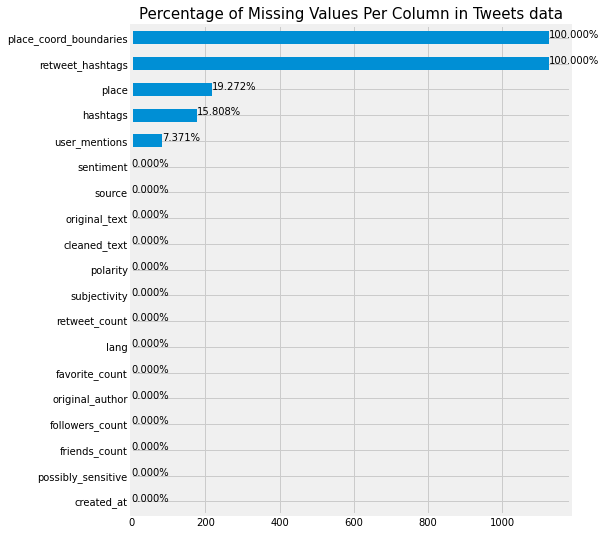

In [28]:
# Check the percentage of missing values in every column
ax = df_tweet.isna().sum().sort_values().plot(kind = 'barh', figsize = (7, 9))
plt.title('Percentage of Missing Values Per Column in Tweets data', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.3f}%'.format((p.get_width()/df_tweet.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

<AxesSubplot:ylabel='Place'>

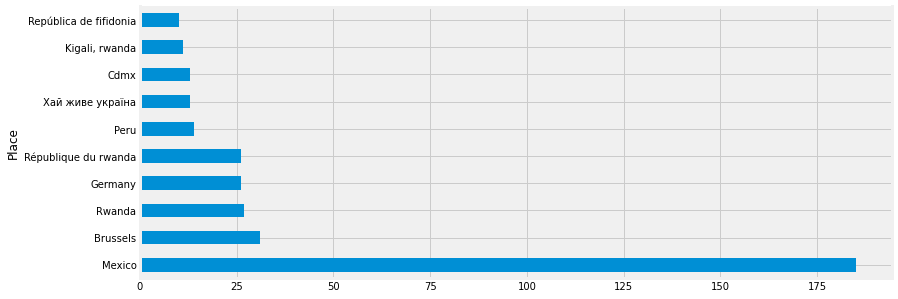

In [29]:
df_tweet['place'].value_counts(sort=True, ascending=False)[:10].plot(kind='barh',
                                                                     figsize=(12,5),xlabel='Place')

In [30]:
df_tweet_date=df_tweet.set_index('created_at')

<AxesSubplot:xlabel='Date,time'>

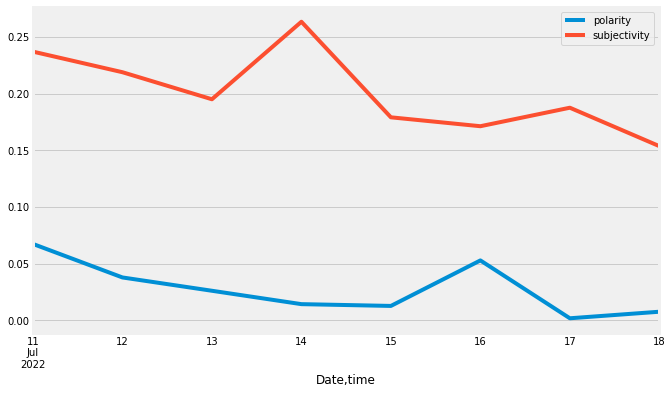

In [31]:
df_tweet_date.resample('D').mean()[['polarity','subjectivity']].dropna().plot(figsize=(10,6),xlabel='Date,time')

### uni-variate Analysis on Hashtags


In [32]:
hashtag_df=df_tweet[['original_text','hashtags','retweet_hashtags']]

In [33]:
def find_hashtags(df_tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', df_tweet)

hashtag_df['hashtag_check']=df_tweet.original_text.apply(find_hashtags)

In [34]:
hashtag_df.dropna(subset=['hashtag_check'],inplace=True)

In [35]:
tags_list=list(hashtag_df['hashtag_check'])

In [36]:
hashtags_list_df = pd.DataFrame([tag for tags_row in tags_list for tag in tags_row],columns=['hashtag'])

In [37]:
hashtags_list_df

,hashtag
0,#M23
1,#DRC
2,#KnowledgeGraphs
3,#abdsc
4,#Semantic
...,...
624,#talks
625,#RDF
626,#Majorit
627,#RDF


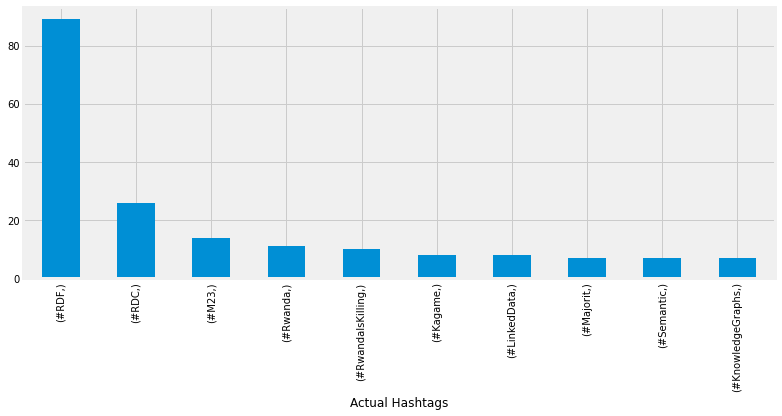

In [38]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Actual Hashtags')

In [39]:
#Convert hastags to lowercase
hashtags_list_df['hashtag'] = hashtags_list_df['hashtag'].str.lower()

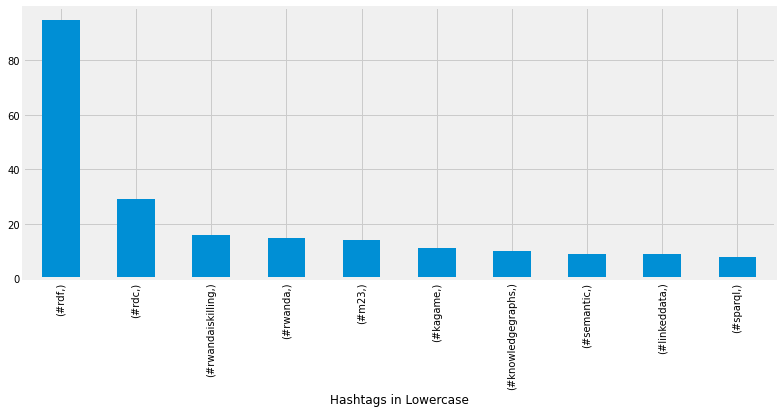

In [40]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Hashtags in Lowercase')

In [41]:
user_summary=df_tweet.groupby('original_author').agg({'cleaned_text':'count','followers_count':'max',
                                         'polarity':'mean','subjectivity':'mean', 'sentiment':pd.Series.mode})

In [42]:
user_summary.sort_values(by='cleaned_text',ascending=False).head(10)

,cleaned_text,followers_count,polarity,subjectivity,sentiment
original_author,,,,,
123_INFO_DE,100,118,0.020725,0.156972,Neutral
Noticieros_MEX,78,4915,-0.032678,0.227569,Neutral
EUwatchers,52,25730,-0.009623,0.183093,Neutral
rogue_corq,34,1834,0.016583,0.168469,Neutral
bouche_bee,25,2836,0.041667,0.138667,Neutral
EtudesRwanda,20,500,0.000000,0.000000,Neutral
acute_tomato,14,17388,-0.036905,0.198810,Neutral
East_DRC_News,14,1262,0.000000,0.000000,Neutral
PhotoFinishBot,13,131,0.017486,0.577119,Neutral


Sentiment summary of the tweets

In [43]:
text_grouped = df_tweet.groupby('sentiment').count()['cleaned_text'].reset_index()

In [44]:
text_grouped

,sentiment,cleaned_text
0,Negative,159
1,Neutral,698
2,Positive,269


<AxesSubplot:xlabel='sentiment', ylabel='count'>

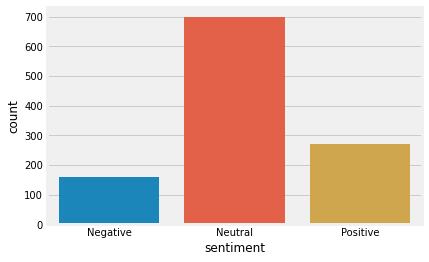

In [45]:
sns.countplot(x='sentiment', data=df_tweet)

**Most frequent words in our tweets dataset**

In [46]:
english_tweets=cleaner.remove_non_english_tweets(df_tweet)

In [47]:
# text Preprocessing
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].str.lower()
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].apply(
    lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
all_words=' '.join(english_tweets.cleaned_text.values)
wordcloud_obj=WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(all_words)

In [ ]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_obj)
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

### Topic modeling

In [ ]:
def preprocess_data(tweets_df):
    # Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['cleaned_text']]
    word_list = [sent.split() for sent in sentence_list]
    #Save only words and excludes emojis, punctuations
    word_list_new=[]
    for sent in word_list:
        word_list_new.append([re.split(r'\W+',word) for word in sent if word not in STOPWORDS and not word.isdigit()])
    
    word_list_final=[]
    for sent in word_list_new:
        word_list_final.append([i[0] for i in sent])
    # Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list_final)
    corpus_1 = [word_to_id.doc2bow(tweet) for tweet in word_list_final]

    return word_list_final, word_to_id, corpus_1

In [ ]:
word_list, id2word, corpus=preprocess_data(english_tweets)

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [ ]:
pprint(lda_model.show_topics(formatted=False))

### Model Analysis

In [ ]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

**Model 1 words with some digits, 5 topics**

Perplexity:  -9.857909007134007\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4242327533406264

**Model 2 words without digits, 5 topics**

Perplexity:  -9.82031321033761\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4368570452021986

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

**Number of Topics optimatization**

As we can see the coherence accuracy increases with number of topics which is expected but again \
many topics again would lead to meaningless conclusion. Let's use elbow method to find optimum number of topics

In [ ]:
# Find best LDA Model considering different number of topics

params_dic={'topics_number':[],'coherence':[],'perplexity':[]}
for top_number in range(1,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            id2word=id2word,
                                            num_topics=top_number, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=False)
    
    perplexity=lda_model.log_perplexity(corpus)  
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    params_dic['topics_number'].append(top_number)
    params_dic['coherence'].append(coherence_lda)
    params_dic['perplexity'].append(perplexity)

In [ ]:
pd.DataFrame(params_dic).plot(y=['coherence'])
# pd.read_csv("elbow_metrics.csv",index_col=0).plot(y=['coherence'])

In [ ]:
import numpy as np

In [ ]:
alphas = list(np.arange(0.01, 3, 0.1))
alphas.append('symmetric')
alphas.append('asymmetric')
alphas.append('auto')

In [ ]:
# Find best LDA Model considering different number of alpha

params_dic_alpha={'alpha':[],'coherence':[],'perplexity':[]}
for alpha in alphas:
    lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            id2word=id2word,
                                            num_topics=7, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=alpha,
                                            per_word_topics=False)
    
    perplexity=lda_model.log_perplexity(corpus)  
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    params_dic_alpha['alpha'].append(alpha)
    params_dic_alpha['coherence'].append(coherence_lda)
    params_dic_alpha['perplexity'].append(perplexity)

In [ ]:
pd.DataFrame(params_dic_alpha).plot(y='coherence')#.sort_values('coherence',ascending=False)

**Model with selected optimum parameters**

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=False)

In [ ]:
pprint(lda_model.show_topics(formatted=False))

In [ ]:
# Compute Perplexity
#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared